In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean

In [2]:
city = 'Jaipur'
PATH = f'/media/root/data/analysis/data/Item_wise_data/{city}/'

In [3]:
# data read
df1 = pd.read_excel(PATH+f'Item_wise-details-{city}-17-23-Dec-2021.xlsx')
df2 = pd.read_excel(PATH+f'Item_wise-details-{city}-24-31-Dec-2021.xlsx')

In [4]:
# exclude non baking items
df = pd.concat([df1, df2])
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])

In [5]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(326587, 29)
(326587, 9)
(326587, 10)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
42816,DPI67185,2021-12-17,1,2021-12-17 10:58:45.843,2021-12-17 10:59:02.437,BRD0031,Chicken Pepperoni Stuffed Garl,1,2021-12-17 11:31:41,437
28664,DPI66444,2021-12-17,1,2021-12-17 10:59:03.653,2021-12-17 11:01:11.420,PIZ0117,_SV-Margherita,1,2021-12-17 11:21:15,548
29760,DPI66981,2021-12-17,1,2021-12-17 10:59:10.207,2021-12-17 10:59:52.817,PIZ0130,_PM39-Pizza Mania Golden Corn,1,2021-12-17 11:16:08,463
29761,DPI66981,2021-12-17,1,2021-12-17 10:59:10.207,2021-12-17 10:59:52.880,PIZ0130,_PM39-Pizza Mania Golden Corn,1,2021-12-17 11:16:08,463
39261,DPI66981,2021-12-17,1,2021-12-17 10:59:10.207,2021-12-17 10:59:52.957,BRD0020,BR-Garlic Breadsticks,1,2021-12-17 11:16:08,463


In [6]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
len(allMenuCodes), len(allStoreIds)

(165, 18)

In [7]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [8]:
sampleItem

Location_Code                                 DPI67185
Order_Date                         2021-12-17 00:00:00
Order_Number                                         1
Kitchen_Display_Time        2021-12-17 10:58:45.843000
Oven_Time                   2021-12-17 10:59:02.437000
Menu_Code                                      BRD0031
Item Description        Chicken Pepperoni Stuffed Garl
Quantity                                             1
Delivery_Time                      2021-12-17 11:31:41
prep_time                                          437
Name: 42816, dtype: object

In [9]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [10]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI67185']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Feature 2: Item Type
def getOneHotEncodingItem(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodingItem(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, isOneHotEncodingRequired=False, clubCategoryWise=False):
    if (not isOneHotEncodingRequired):
        if clubCategoryWise:
            return [item['Menu_Code'][0:3]]
        return [item['Menu_Code']]
    else:
        return getOneHotEncodingItem(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [12]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True, True))

['BRD0031']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['BRD']
[1, 0, 0, 0, 0, 0, 0]


In [13]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if isOneHotEncodingRequired:
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [timeslot]

In [14]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [ ]:
#DON"T RUN IT AGAIN AND AGAIN, it will take much more time
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

# Pre-preparation of data
df['pre_prep_time'] = 0

StoreWiseItems = {}
for index, item in df.iterrows():
    store = item['Location_Code']
    if store in StoreWiseItems:
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        count = 0
        pt = 0
        for i in reversed(range(len(StoreWiseItems[store]))):
            if(StoreWiseItems[store][i]['Kitchen_Display_Time'] >= lastTime and StoreWiseItems[store][i]['Kitchen_Display_Time'] < dtKitchenDisplay):
                if(StoreWiseItems[store][i]['Menu_Code'] == item['Menu_Code']):
                    pt += get_preparation_time(item)
                    count+=1
            else:
                break
        if count != 0:
            df['pre_prep_time'][index] = pt/count
        else:
            df['pre_prep_time'][index] = 10*60
        StoreWiseItems[store].append(item)
    else:
        StoreWiseItems[store] = [item]
        df['pre_prep_time'][index] = 10*60

        
storeWiseCumulativeItems = {}
StoreWiseDFs = {}
for store in StoreWiseItems.keys():
    StoreWiseDFs[store] = pd.DataFrame.from_dict(StoreWiseItems[store])
    storeWiseCumulativeItems[store] = {}

# item count per slot
for store in StoreWiseItems.keys():
    for item in StoreWiseItems[store]:
        date = item['Order_Date']
        minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
        if date in storeWiseCumulativeItems[store]:
            storeWiseCumulativeItems[store][date][minuteSlot]+=1
        else:
            t = []
            for i in range(0, 24*60):
                t.append(0)
            storeWiseCumulativeItems[store][date] = t
            storeWiseCumulativeItems[store][date][minuteSlot] = 1
            
#prefix sum            
for store in storeWiseCumulativeItems.keys():
    for date in storeWiseCumulativeItems[store].keys():
        for i in range(1, 24*60):
            storeWiseCumulativeItems[store][date][i] += storeWiseCumulativeItems[store][date][i-1]
            
            
def countPastOrders(item, storeWiseCumulativeItems=storeWiseCumulativeItems, slotTime=30):
    minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
    total = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][minuteSlot]
    prev = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][max(minuteSlot-slotTime, 0)]
    return [(total-prev)]

/tmp/ipykernel_66698/2016951000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_66698/2016951000.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_66698/2016951000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = pt/count


In [25]:
print(countPastOrders(sampleItem))
print(countPastOrders(sampleItem, slotTime=10))

d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')
# storeWiseCumulativeItems[sampleItem['Location_Code']][d]

[1]
[1]


In [ ]:
type(StoreWiseItems[sampleItem['Location_Code']])

In [ ]:
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
    orderedItem = item['Menu_Code']
    prepTime = []
    if clubCategoryWise:
        orderedItem = orderedItem[0:3]
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
             & (d['Kitchen_Display_Time'] >= lastTime) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]

    if(len(tdf)>0):
        return [tdf['prep_time'].mean()]
    else:
        return [10*60]


# def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
#     dtKitchenDisplay = item['Kitchen_Display_Time']
#     lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
#     orderedItem = item['Menu_Code']
#     prepTime = []
#     if clubCategoryWise:
#         orderedItem = orderedItem[0:3]
#     tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
#              & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]

#     if(len(tdf)>0):
#         return [tdf['prep_time'].mean()]
#     else:
#         return [10*60]

    
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    
#     prepTime = []
#     tdf = df[(df['Location_Code']==item['Location_Code']) & \
#              (df['Oven_Time'] >= dtKitchenDisplay) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    return len(tdf.index)
#     for order in StoreWiseItems[item['Location_Code']]:
#         if(order['Kitchen_Display_Time'] >= lastTime and order['Kitchen_Display_Time'] <= dtKitchenDisplay):
#             if (order['Menu_Code'][0:len(orderedItem)] == orderedItem):
#                 prepTime.append(get_preparation_time(order))
#     if(len(prepTime) > 0):
#         return [mean(prepTime)]
#     else:
#         return [10*60] # POINT OF DISCUSSION, For now taking 10 minutes

In [ ]:
getPreviousPrepTime(sampleItem, StoreWiseItems, False, 60)
lengthQueue(sampleItem)

In [ ]:
item = sampleItem
orderedItem = item['Menu_Code']
orderedItem = orderedItem[0:3]
dtKitchenDisplay = item['Kitchen_Display_Time']
lastTime = dtKitchenDisplay - timedelta(minutes=60)
tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
         & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
print(item, len(tdf)) 
if(len(tdf)>0):
    print([round(tdf['prep_time'].mean())])
tdf

In [ ]:
# global variables

isThresholdForPreparationTime = False
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

In [ ]:
sampleItem

In [53]:
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
    if(i%1000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t

    t = time.time()    
    
    features = features + [lengthQueue(item)]
    
    t6 += time.time() - t
    t = time.time()
    X.append(features)
    
    y.append(get_preparation_time(item))
    t7 += time.time() - t

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)

0.03513073921203613 0.04001951217651367 0.059610843658447266 1.3206377029418945 5.232754945755005 1.3103673458099365 0.02314591407775879
0.07103919982910156 0.08067703247070312 0.12557363510131836 2.918303966522217 10.461041450500488 2.630033016204834 0.046590328216552734
0.10741543769836426 0.12194633483886719 0.19578099250793457 4.723565340042114 15.739164352416992 3.9697153568267822 0.07084870338439941
0.14417600631713867 0.16269230842590332 0.26776766777038574 6.6501784324646 21.072232246398926 5.310716390609741 0.09488534927368164
0.17983627319335938 0.2023937702178955 0.3304286003112793 8.10477089881897 26.22684669494629 6.631551504135132 0.11853909492492676
0.2154231071472168 0.2416543960571289 0.39308834075927734 9.524775981903076 31.428694486618042 7.960343360900879 0.14212846755981445
0.25078415870666504 0.2806432247161865 0.45739293098449707 11.103805780410767 36.484747886657715 9.270932912826538 0.16578030586242676
0.2865767478942871 0.32022762298583984 0.5254647731781006 1

2.2335195541381836 2.5818588733673096 4.175889492034912 106.54505467414856 327.91507029533386 82.87337493896484 1.4697282314300537
2.2704379558563232 2.624523401260376 4.24113917350769 108.1054790019989 333.229553937912 84.2304265499115 1.4947514533996582
2.3087363243103027 2.669220447540283 4.312583684921265 109.94489669799805 338.7506446838379 85.60371398925781 1.5194158554077148
2.3453869819641113 2.711085796356201 4.381859540939331 111.81079745292664 344.0103385448456 86.9432361125946 1.5434024333953857
2.382643461227417 2.754300594329834 4.450257062911987 113.56805419921875 349.3545322418213 88.30313491821289 1.5676543712615967
2.41904616355896 2.7967095375061035 4.513312578201294 115.04118204116821 354.68721175193787 89.64115190505981 1.5915887355804443
2.4548089504241943 2.8385305404663086 4.580286502838135 116.79338002204895 359.9447612762451 90.95221066474915 1.615023136138916
2.4899673461914062 2.880108118057251 4.649165630340576 118.64383101463318 365.17938256263733 92.24505

In [26]:
len(X), len(y), len(X[0])

(326587, 326587, 210)

In [62]:
bakeup_X = X
bakeup_y = y

In [63]:
n = len(allStoreIds)
store_wise_X = [[] for _ in range(n)]
store_wise_y = [[] for _ in range(n)]

for j in range(n):
    for i in range(len(X)):
        if X[i][j] > 0:
            store_wise_X[j].append(X[i][n:])
            store_wise_y[j].append(y[i])

# store_wise_X = [[x for x in X] for j in range(n)]
# store_wise_X = [x for j in range(n) for _,y in zip(X,y) if x[j]>0]

In [64]:
l = []

for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
#     print("Random Forest Model", i, len(y_train), len(y_test))
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    a = getRMSE(y_train, predictions)
#     print("RMSE score on train set: ", a)
    
    predictions = regressor.predict(X_test)
    b = getRMSE(y_test, predictions)
#     print("RMSE score on test set: ", b)
    l.append((a, b, len(y_train), len(y_test)))
l

[(18.546003170587817, 46.20067367695243, 7785, 1947),
 (11.570884019191867, 29.902409673769686, 6954, 1739),
 (19.876884476880075, 52.04437978154525, 8168, 2043),
 (15.554651852431618, 38.60970257186415, 3782, 946),
 (13.014989336860484, 32.40118288810427, 4944, 1237),
 (6.65193912341794, 17.389537221658966, 4546, 1137),
 (16.577605496937057, 41.24907456376325, 5149, 1288),
 (18.787366568005062, 54.37880200928217, 6744, 1687),
 (10.114216708862948, 26.41233547228314, 5093, 1274),
 (15.314460882861377, 41.28464382734169, 7277, 1820),
 (9.431175736786551, 29.776145739433094, 7198, 1800)]

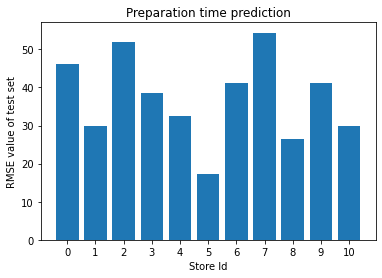

[46.20067367695243,
 29.902409673769686,
 52.04437978154525,
 38.60970257186415,
 32.40118288810427,
 17.389537221658966,
 41.24907456376325,
 54.37880200928217,
 26.41233547228314,
 41.28464382734169,
 29.776145739433094]

In [65]:
X_t = [i for i in range(11)]
Y_t = [x[1] for x in l]
Y_t, X_t
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()
Y_t

In [49]:
# l = [len(x) for x in store_wise_y]
# sum(l)
# len(store_wise_X[0][0]), n
# Y_t = l[:][1]
# Y_t
X_t = [i for i in range(11)]
Y_t = [x[1] for x in l]
Y_t, X_t

([46.474329866513,
  30.378945504039407,
  51.76135265403258,
  38.465051022292506,
  32.30800862059353,
  17.65975373869952,
  41.47104984259385,
  54.02779294717718,
  26.479798936643498,
  41.46850661965206,
  29.7014803993898],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [68]:
l2 = [(a**2)*b for _,a,_,b in l]
l3 = [b for _,_,_,b in l]
combine_rmse = (sum(l2)/sum(l3))**(1/2)
combine_rmse

39.99643963990101

In [55]:
if splitMethod == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [56]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [57]:
# random forest
if (model=='RF'):
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))
    

Random Forest Model
RMSE score on train set:  15.505474488066628
RMSE score on test set:  40.61493904814495


In [27]:
predictions = regressor.predict(X_train)
print("RMSE score on train set: ", getRMSE(y_train, predictions))

predictions = regressor.predict(X_test)
print("RMSE score on test set: ", getRMSE(y_test, predictions))

RMSE score on train set:  15.48396217619703
RMSE score on test set:  40.74616528012841


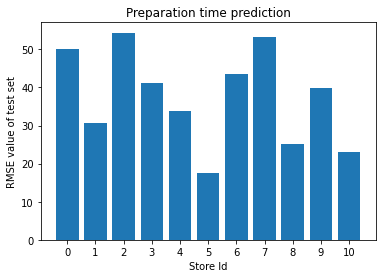

In [58]:
X_t = []
Y_t = []
for j in range(0, len(allStoreIds)):
    xx = []
    yy = []
    for i in range(0, len(X_test)):
        if(X_test[i][j] > 0):
            xx.append(X_test[i])
            yy.append(y_test[i])
    X_t.append(j)
    Y_t.append(getRMSE(yy, regressor.predict(xx)))
    
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()

In [60]:
Y_t_all = Y_t
Y_t_all

[50.06500761458387,
 30.791504301726302,
 54.38019089324753,
 41.08481611853637,
 33.85700041073424,
 17.447795882728666,
 43.453666175875064,
 53.31073821329999,
 25.182759213882008,
 39.937293076362835,
 23.17185346045179]

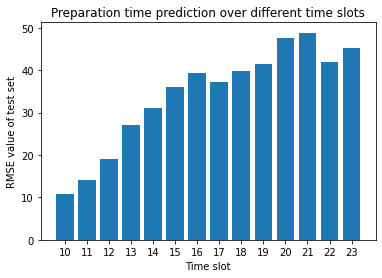

In [61]:
X_Axis = [i for i in range(10, 24)]
RMSETimeSlotWise = {}
total_items = len(allMenuCodes)+len(allStoreIds)
for x in X_Axis:
    x1 = []
    y1 = []
    for i in range(0, len(X_test)):
        if(X_test[i][total_items+x] > 0):
            x1.append(X_test[i])
            y1.append(y_test[i])
    RMSETimeSlotWise[x] = getRMSE(y1, regressor.predict(x1))
    
X_axis = list(RMSETimeSlotWise.keys())
Y_axis = list(RMSETimeSlotWise.values())

plt.bar(X_axis, Y_axis)
plt.xticks(X_axis)
plt.xlabel("Time slot")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction over different time slots")
plt.show()

In [76]:
y = []
for i in X_t:
#     y.append((Y_t[i], Y_t_all[i]))
    print(i, Y_t[i], Y_t_all[i])
#     if Y_t_all[x][y] = 4
    
# y

0 46.20067367695243 50.06500761458387
1 29.902409673769686 30.791504301726302
2 52.04437978154525 54.38019089324753
3 38.60970257186415 41.08481611853637
4 32.40118288810427 33.85700041073424
5 17.389537221658966 17.447795882728666
6 41.24907456376325 43.453666175875064
7 54.37880200928217 53.31073821329999
8 26.41233547228314 25.182759213882008
9 41.28464382734169 39.937293076362835
10 29.776145739433094 23.17185346045179


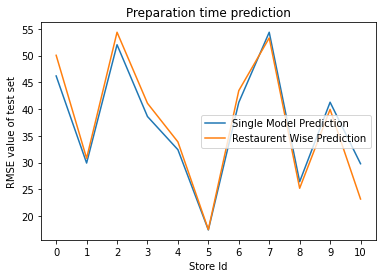

In [75]:
# plt.plot(X_t, Y_t, label = 'Single Model Prediction')
# plt.plot(X_t, Y_t_all, label = 'Restaurent Wise Prediction')

plt.plot(X_t, y)
plt.legend(['Single Model Prediction', 'Restaurent Wise Prediction'])

plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()

In [89]:
# #activation: relu, logistic
# def ModelResults(X_train, X_test, y_train, y_test, model, isNormalizationRequired=True):
    
#     if(isNormalizationRequired):
#         scaler = StandardScaler()
#         scaler.fit(X_train)

#         X_train = scaler.transform(X_train)
#         X_test = scaler.transform(X_test)
        
#     if(model=='NN'):
#         hidden_layer_sizes=(80, 30, 10)
#         activation='relu'
#         print("Neural Network model")
#         print("Hidden layers: ", hidden_layer_sizes)
#         print("Activation function: ", activation)
#         mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=1000, verbose=True, learning_rate='constant', learning_rate_init=0.01)
#         mlp.fit(X_train, y_train)
#         print(mlp.best_loss_)
        
#         predictions = mlp.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = mlp.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
        
#     elif(model=='RF'):
#         print("Random Forest Model")
#         regressor = RandomForestRegressor()
#         regressor.fit(X_train, y_train)
        
#         predictions = regressor.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = regressor.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
#     else:
#         print("Model not implemented yet")

In [86]:
# mlp.predict_log_proba(X)

array([[ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       ...,
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635]])

In [ ]:

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# regressor = RandomForestRegressor()
# regressor.fit(X_train, y_train)
# predictions = regressor.predict(X_train)

In [39]:
for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))
    

Random Forest Model
RMSE score on train set:  18.25602531368394
RMSE score on test set:  45.815872729249435
Random Forest Model
RMSE score on train set:  11.559987090939433
RMSE score on test set:  30.044338900434187
Random Forest Model
RMSE score on train set:  19.8160462425246
RMSE score on test set:  51.44029530615877
Random Forest Model
RMSE score on train set:  15.56732234897142
RMSE score on test set:  38.72006453737753
Random Forest Model
RMSE score on train set:  13.430966752860824
RMSE score on test set:  32.58723421931361
Random Forest Model
RMSE score on train set:  6.599369874774
RMSE score on test set:  17.39437297020862
Random Forest Model
RMSE score on train set:  16.52015385356523
RMSE score on test set:  41.19153062656546
Random Forest Model
RMSE score on train set:  18.478996784796827
RMSE score on test set:  54.17347072479103
Random Forest Model
RMSE score on train set:  9.99238771234968
RMSE score on test set:  26.468487048872355
Random Forest Model
RMSE score on tr

In [ ]:
# mse = sklearn.metrics.mean_squared_error(y_train, predictions)  
# rmse = math.sqrt(mse)  
# rmse